In [344]:
import numpy as np
import glob
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None  # default='warn'
import scipy.stats as stats
from scipy.stats import wilcoxon
import ast

In [345]:
import re

def extract_number_after_pro_or_stu(filename):
    """
    Extracts the number following 'pro' or 'stu' from the given filename using regular expressions.

    Parameters:
    - filename (str): The filename from which to extract the number.

    Returns:
    - str or None: The number following 'pro' or 'stu' if found, otherwise None.
    """
    match = re.search(r'(?:pro|stu)(\d+)', filename)
    if match:
        return match.group(1)
    else:
        return None


In [346]:
from collections import defaultdict
def get_probabilities_action(dataframe, current_phase):
    actions = ['same', 'modify-1', 'modify-2', 'modify-3']

    # Count occurrences of each action
    action_counts = dataframe['Action'].value_counts()

    # Initialize probabilities dictionary with all actions having probability 0
    probabilities = defaultdict(lambda: 0)

    # Update probabilities based on counts
    total_actions = len(dataframe)
    for action in actions:
        if action in action_counts and action_counts[action] > 0:
            # Calculate probability for the current action
            probabilities[action] = action_counts[action] / total_actions
        else:
            # Set probability to 0 if the action does not exist
            probabilities[action] = None

    return probabilities[current_phase]



In [347]:
def get_action_counts(dataframe, current_phase):
    actions = ['same', 'modify-1', 'modify-2', 'modify-3']

    # Initialize counts array with zeros for all actions
    action_counts = {action: 0 for action in actions}

    # Count occurrences of each action
    for action in actions:
        count = dataframe[dataframe['Action'] == action].shape[0]
        if count is not None:  # Update count if action exists
            action_counts[action] = count

    # Convert dictionary to list, ensuring length is exactly 4
    action_counts_list = [action_counts[action] for action in actions]

    return action_counts_list[actions.index(current_phase)]


In [348]:
def get_action_rate(dataframe, current_phase):
    if len(dataframe) < 2:
        return 0, 0
    actions = ['same', 'modify-1', 'modify-2', 'modify-3']

    # Initialize counts array with zeros for all actions
    action_counts = {action: 0 for action in actions}

    # Count occurrences of each action
    for action in actions:
        count = dataframe[dataframe['Action'] == action].shape[0]
        if count is not None:  # Update count if action exists
            action_counts[action] = count

    # Convert dictionary to list, ensuring length is exactly 4
    action_counts_list = [action_counts[action] for action in actions]

    # Calculate total time in minutes
    total_time_minutes = (dataframe['Time'].max() - dataframe['Time'].min()) / (1000*60.0)



    # Calculate action rate per minute for the current phase
    action_rate_per_minute = action_counts_list[actions.index(current_phase)] / total_time_minutes

    return action_rate_per_minute, total_time_minutes


In [349]:
def get_attributes_counts(dataframe, current_phase):
    actions = ['Title', 'US_Gross', 'Worldwide_Gross', 'US_DVD_Sales', 'Production_Budget', 'Release_Date',
           'MPAA_Rating', 'Running_Time_min', 'Distributor', 'Source', 'Major_Genre', 'Creative_Type',
           'Director', 'Rotten_Tomatoes_Rating', 'IMDB_Rating', 'IMDB_Votes', 'None']

    # Initialize counts dictionary with zeros for all attributes
    attribute_counts = {attr: 0 for attr in actions}

    # Count occurrences of each attribute
    for attr in actions:
        count = 0  # Initialize count for the current attribute
        for index, row in dataframe.iterrows():  # Iterate over rows in the DataFrame
            # Check if the current attribute exists in the row and increment count if it does
            if attr in ast.literal_eval(row['Attribute']):
                count += 1
        attribute_counts[attr] = count  # Update count for the current attribute

    # Convert dictionary to list, ensuring length matches the number of attributes
    attribute_counts_list = [attribute_counts[attr] for attr in actions]

    return attribute_counts_list


In [350]:
def get_attributes_unique(dataframe):
    """
    Count the number of unique attributes interacted with in a given phase of the dataframe.

    Args:
        dataframe (pd.DataFrame): DataFrame containing interaction data.

    Returns:
        int: Number of unique attributes interacted with.
    """
    # Initialize a set to store unique attributes
    unique_attributes = set()

    # Iterate over rows in the DataFrame
    for index, row in dataframe.iterrows():
        # Extract attributes from the 'Attribute' column and update the set
        attributes = ast.literal_eval(row['Attribute'])  # Safely evaluate the attribute list
        unique_attributes.update(attributes)

    # Return the count of unique attributes
    return len(unique_attributes)

In [351]:
import ast

def get_probabilities(dataframe, current_phase):
    map = ['Title', 'US_Gross', 'Worldwide_Gross', 'US_DVD_Sales', 'Production_Budget', 'Release_Date',
           'MPAA_Rating', 'Running_Time_min', 'Distributor', 'Source', 'Major_Genre', 'Creative_Type',
           'Director', 'Rotten_Tomatoes_Rating', 'IMDB_Rating', 'IMDB_Votes', 'None']

    # Initialize dictionary to store counts
    dict_map = dict.fromkeys(map, 0)

    # Count occurrences of each field
    total_count = 0
    for index, row in dataframe.iterrows():
        for field in ast.literal_eval(row['Attribute']):
            dict_map[field] += 1
            total_count += 1

    return dict_map[current_phase]



In [352]:
def normalize_arrays(arr1, arr2):
     # Convert input arrays to numpy arrays
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    # Calculate the sum of each array
    sum1 = np.sum(arr1)
    sum2 = np.sum(arr2)

    # Compute scaling factors
    scale_factor1 = sum2 / sum1
    scale_factor2 = sum1 / sum2

    # Multiply each element by the corresponding scaling factor
    normalized_arr1 = arr1 * scale_factor1
    normalized_arr2 = arr2 * scale_factor2

    return normalized_arr1, normalized_arr2

In [354]:
def split_dataframe(df, splits=4):
    # Sort the DataFrame by the "Time" column
    df = df.sort_values(by="Time")

    # Get the minimum and maximum UNIX timestamps
    min_time = df['Time'].min()
    max_time = df['Time'].max()

    # Calculate the time interval size
    interval_size = (max_time - min_time) / splits

    slices = []
    start_time = min_time
    for i in range(splits):
        # Determine the end time of the current interval
        end_time = start_time + interval_size

        # Filter the DataFrame based on the time range
        slice_df = df[(df['Time'] >= start_time) & (df['Time'] < end_time)].reset_index(drop=True)

        slices.append(slice_df)

        # Update the start time for the next interval
        start_time = end_time

    return slices

In [355]:
def get_user_name(url):
    parts = url.split('/')
    fname = parts[-1]
    uname = fname.split('_')[0]  # Extracting the part after the first underscore
    return uname


In [356]:
def get_experiment_condition(url):
    parts = url.split('/')
    fname = parts[-1]
    condition = fname.split('_')[1]  # Extracting the part after the first underscore
    #extract the part before the first underscore
    condition = condition.split('.')[0]
    return condition

In [360]:

import warnings
def create_linear_models_data(fileNames2D, task, dataset='movies'):
    sketchy_user=[]
    if 'p1' in task or 'p2' in task:
        openendedness = 'focused'
    else:
        openendedness = 'open'

    actions_all = ['same', 'modify-1', 'modify-2', 'modify-3']
    # Suppress FutureWarning related to DataFrame concatenation
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
           # Initialize an empty list to store the dictionaries
        data = []

        for i, u in enumerate(fileNames2D):
            state = get_user_name(u)

            print(f"\nProcessing test for user: {state}")
            df = pd.read_csv(u)
            # for index, row in df.iterrows():
            #     file_data = {'u': state}
            #     # get index of row['Value'] from action_all list
            #     actions_all = ['same', 'modify-1', 'modify-2', 'modify-3']
            #     file_data['probab'] = actions_all.index(row['Action'])
            #     file_data['Trial'] = index
            #     data.append(file_data)
            slices = split_dataframe(df,2)
            print (f"Size of slices: {len(slices[0]), len(slices[1])}")
            # if len(slices[0]) < 1 or len(slices[1]) < 1:
            #     print(f"User {state} has less than 2 interactions for task {task}. ")
            #     sketchy_user.append(state)
            #
            # # #make everyhting 0 for slice with no interaction
            # # if len(slices[0]) < 1:
            # #     slices[0] = pd.DataFrame(columns=['Action', 'Attribute', 'Time'])
            # # if len(slices[1]) < 1:
            # #     slices[1] = pd.DataFrame(columns=['Action', 'Attribute', 'Time'])
            #
            # else:

            # List of all actions
            actions_all = ['same', 'modify-1', 'modify-2', 'modify-3']
            trial_index = 0
            min=0
            for j, slice_df in enumerate(slices):
                # Create dictionary for each action and slice
                file_data = {'u': state, 'Trial': j, 'Task': task, 'Dataset':dataset , 'Experiment': dataset+get_experiment_condition(u), 'Openendedness': openendedness}
                for action in actions_all:
                    # Collect all probabilities
                    probab = get_probabilities_action(slice_df, action)
                    # if probab == 0:
                    #     print(f"User {state} has 0 probability for action {action} in slice {j}. ")
                    #     sketchy_user.append(state)
                    #
                    # else:
                    #

                    print(f"User {state} has {probab} probability for action {action} in slice {j}. ")
                    # Remove hyphen from action name
                    action_key = action.replace('-', '')
                    # Add probabilities to the dictionary


                    file_data[f"probab{action_key}"] = probab
                data.append(file_data)



    # Create DataFrame
    df = pd.DataFrame(data)
    filepath = "./data/zheng/mixed-model-data/"
    print(f"################ Before Remove nulls  {len(df)}")
    filename=f'zheng_{dataset}_{task}.csv'
    df.to_csv(filepath+filename, index=False)
    print(f"################  After Remove nulls  {len(df)}")
    return sketchy_user



In [361]:
# This is for Logistic Regression
def generate_combined_data(fileNames2D,task):
    data = []

    for i, u in enumerate(fileNames2D):
        state = get_user_name(u)

        print(f"\nProcessing test for user: {state}")
        df = pd.read_csv(u)
        slices = split_dataframe(df,4)
        print (f"Size of slices: {len(slices[0]), len(slices[1])}")
        for j, slice_df in enumerate(slices):
          for index, row in slice_df.iterrows():
            print(row['Action'])
            # Create dictionary for each action and slice
            file_data = {'u': state, 'Trial': j, 'Action': row['Action'], 'Attribute': row['Attribute'], 'Time': row['Time'], 'Task': task,'User_index':index}
            data.append(file_data)


    # Create DataFrame
    df = pd.DataFrame(data)
    filename=f'zheng_logistic_{task}.csv'
    print(f"################ Data has been saved to {len(df)}")
    df.to_csv(filename, index=False)
    print(f"################ Null has has been saved to {len(df)}")
    return None


In [373]:
fileNamesP1 = np.sort(glob.glob("./data/zheng/processed_interactions_p1/*"))
fileNamesP2 = np.sort(glob.glob("./data/zheng/processed_interactions_p2/*"))
fileNamesP3 = np.sort(glob.glob("./data/zheng/processed_interactions_p3/*"))
fileNamesP4 = np.sort(glob.glob("./data/zheng/processed_interactions_p4/*"))


create_linear_models_data(fileNamesP1, 'p1', dataset='movies')
create_linear_models_data(fileNamesP2, 'p2', dataset='movies')
create_linear_models_data(fileNamesP3, 'p3', dataset='movies')
create_linear_models_data(fileNamesP4, 'p4', dataset='movies')

In [374]:
fileNamesP1Birdstrikes = np.sort(glob.glob("./data/zheng/birdstrikes_processed_interactions_p1/*"))
fileNamesP2Birdstrikes = np.sort(glob.glob("./data/zheng/birdstrikes_processed_interactions_p2/*"))
fileNamesP3Birdstrikes = np.sort(glob.glob("./data/zheng/birdstrikes_processed_interactions_p3/*"))
fileNamesP4Birdstrikes = np.sort(glob.glob("./data/zheng/birdstrikes_processed_interactions_p4/*"))

create_linear_models_data(fileNamesP1Birdstrikes, 'p1', dataset='birdstrikes')
create_linear_models_data(fileNamesP2Birdstrikes, 'p2', dataset='birdstrikes')
create_linear_models_data(fileNamesP3Birdstrikes, 'p3', dataset='birdstrikes')
create_linear_models_data(fileNamesP4Birdstrikes, 'p4', dataset='birdstrikes')




Processing test for user: pro13

Processing test for user: pro15

Processing test for user: pro17

Processing test for user: pro18

Processing test for user: pro20

Processing test for user: pro21

Processing test for user: pro22

Processing test for user: pro23

Processing test for user: pro24

Processing test for user: pro25

Processing test for user: pro29

Processing test for user: pro31

Processing test for user: pro3

Processing test for user: pro5

Processing test for user: pro8

Processing test for user: pro9

Processing test for user: stu10

Processing test for user: stu11

Processing test for user: stu13

Processing test for user: stu15

Processing test for user: stu17

Processing test for user: stu21

Processing test for user: stu24

Processing test for user: stu25

Processing test for user: stu26

Processing test for user: stu29

Processing test for user: stu30

Processing test for user: stu31

Processing test for user: stu36

Processing test for user: stu37

Processing te

In [364]:
#SANITY CHECK
def sanity_check_final_dataframes(dataset):
    df1= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_{dataset}_p1.csv')
    df2= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_{dataset}_p2.csv')
    df3= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_{dataset}_p3.csv')
    df4= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_{dataset}_p4.csv')
    # assert df1.shape == df2.shape == df3.shape == df4.shape
    print(f"Sanity check passed for {dataset} dataframes")




In [365]:
sanity_check_final_dataframes('birdstrikes')

Sanity check passed for birdstrikes dataframes


In [366]:
def master_joined_test_both_dataset():
    df1= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_movies_p1.csv')
    df2= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_movies_p2.csv')
    df3= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_movies_p3.csv')
    df4= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_movies_p4.csv')
    df5= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_birdstrikes_p1.csv')
    df6= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_birdstrikes_p2.csv')
    df7= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_birdstrikes_p3.csv')
    df8= pd.read_csv(f'./data/zheng/mixed-model-data/zheng_birdstrikes_p4.csv')
    movies = pd.concat([df1, df2, df3, df4], ignore_index=True)
    birdstrikes = pd.concat([df5, df6, df7, df8], ignore_index=True)
    both_datasets = pd.concat([movies, birdstrikes], ignore_index=True)
    #sort the dataframe by u
    both_datasets = both_datasets.sort_values(by=['u', 'Task', 'Experiment'])
    both_datasets.to_csv('./data/zheng/mixed-model-data/zheng_both_datasets.csv', index=False)
    print(f"################ Data has been saved to zheng_both_datasets.csv")
    return both_datasets

In [367]:
def master_sanity_check(master_df):
    assert dataset.isna().any().any() == False
    print(f"Null Sanity check 1 passed for master dataframe")
    # for each 'u' and each task there should be 2 rows
    assert master_df.shape[0]==len(master_df['u'].unique())*len(master_df['Task'].unique())*len(master_df['Experiment'].unique())
    print(f"Sanity check 2 passed for master dataframe")




In [368]:
dataset=master_joined_test_both_dataset()
master_sanity_check(dataset)


################ Data has been saved to zheng_both_datasets.csv
Null Sanity check 1 passed for master dataframe


AssertionError: 

In [369]:
dataset

,u,Trial,Task,Dataset,Experiment,Openendedness,probabsame,probabmodify1,probabmodify2,probabmodify3
300,pro1,0,p1,birdstrikes,birdstrikesbcf,focused,0.307692,0.307692,0.384615,0.000000
301,pro1,1,p1,birdstrikes,birdstrikesbcf,focused,0.400000,0.000000,0.600000,0.000000
372,pro1,0,p2,birdstrikes,birdstrikesbcf,focused,0.444444,0.333333,0.222222,0.000000
373,pro1,1,p2,birdstrikes,birdstrikesbcf,focused,0.647059,0.235294,0.117647,0.000000
444,pro1,0,p3,birdstrikes,birdstrikesbcf,open,0.544444,0.133333,0.266667,0.055556
...,...,...,...,...,...,...,...,...,...,...
431,stu9,1,p2,birdstrikes,birdstrikesbcf,focused,1.000000,0.000000,0.000000,0.000000
502,stu9,0,p3,birdstrikes,birdstrikesbcf,open,0.692308,0.201923,0.105769,0.000000
503,stu9,1,p3,birdstrikes,birdstrikesbcf,open,0.722222,0.111111,0.152778,0.013889
574,stu9,0,p4,birdstrikes,birdstrikesbcf,open,0.491525,0.152542,0.355932,0.000000


In [370]:

dataset

,u,Trial,Task,Dataset,Experiment,Openendedness,probabsame,probabmodify1,probabmodify2,probabmodify3
300,pro1,0,p1,birdstrikes,birdstrikesbcf,focused,0.307692,0.307692,0.384615,0.000000
301,pro1,1,p1,birdstrikes,birdstrikesbcf,focused,0.400000,0.000000,0.600000,0.000000
372,pro1,0,p2,birdstrikes,birdstrikesbcf,focused,0.444444,0.333333,0.222222,0.000000
373,pro1,1,p2,birdstrikes,birdstrikesbcf,focused,0.647059,0.235294,0.117647,0.000000
444,pro1,0,p3,birdstrikes,birdstrikesbcf,open,0.544444,0.133333,0.266667,0.055556
...,...,...,...,...,...,...,...,...,...,...
431,stu9,1,p2,birdstrikes,birdstrikesbcf,focused,1.000000,0.000000,0.000000,0.000000
502,stu9,0,p3,birdstrikes,birdstrikesbcf,open,0.692308,0.201923,0.105769,0.000000
503,stu9,1,p3,birdstrikes,birdstrikesbcf,open,0.722222,0.111111,0.152778,0.013889
574,stu9,0,p4,birdstrikes,birdstrikesbcf,open,0.491525,0.152542,0.355932,0.000000


In [371]:
dataset.isna()

,u,Trial,Task,Dataset,Experiment,Openendedness,probabsame,probabmodify1,probabmodify2,probabmodify3
300,False,False,False,False,False,False,False,False,False,False
301,False,False,False,False,False,False,False,False,False,False
372,False,False,False,False,False,False,False,False,False,False
373,False,False,False,False,False,False,False,False,False,False
444,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
431,False,False,False,False,False,False,False,False,False,False
502,False,False,False,False,False,False,False,False,False,False
503,False,False,False,False,False,False,False,False,False,False
574,False,False,False,False,False,False,False,False,False,False


# # DATA VISUALIZATION


In [ ]:
# Iterate through each row and construct the new DataFrame
# New DataFrame columns
new_columns = ['u', 'Trial', 'action', 'probab']
new_data = []
for _, row in df.iterrows():
    for i in ['same', 'modify1', 'modify2', 'modify3']:
        action = f"probab{i}"
        probab = row[action]
        if probab != 0:
            new_data.append([row['u'], row['Trial'], action, probab])

new_df = pd.DataFrame(new_data, columns=new_columns)

new_df

In [396]:
new_df.isna().any()

   Task  Total_interactions  Min_interactions  Max_interactions  \
0     0                1520                 7               113   
1     1                1867                14               142   
2     2                5737                67               296   
3     3                5835                59               358   

   Median_interactions  Count_same  Count_modify-1  Count_modify-2  \
0                 34.0        1015             386             115   
1                 38.5        1159             455             228   
2                149.0        3095            1444            1083   
3                145.5        3179            1723             873   

   Count_modify-3  Percent_same  Percent_modify-1  Percent_modify-2  \
0               4     66.776316         25.394737          7.565789   
1              25     62.078200         24.370648         12.212105   
2             115     53.948056         25.169949         18.877462   
3              60     54.4815

/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_21249/2836838625.py:14: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  action_counts = task_data["Action_counts"].apply(pd.Series).fillna(0).sum()
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_21249/2836838625.py:14: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  action_counts = task_data["Action_counts"].apply(pd.Series).fillna(0).sum()
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_21249/2836838625.py:14: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  action_counts = task_data["Action_counts"].apply(pd.Series).fillna(0).sum()
/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipyker

In [397]:
import seaborn as sns
def plot_probabilities(data):
    # Convert the 'Trial' column to categorical for correct ordering on the plot
    data['Trial'] = pd.Categorical(data['Trial'], categories=['0', '1'], ordered=True)

    # Melt the dataframe to have one column for actions and another for probabilities
    melted_data = pd.melt(data, id_vars=['u', 'Trial'], var_name='Action', value_name='Probability')

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=melted_data, x='Trial', y='Probability', hue='Action', ci=None)
    plt.title('Probabilities of Actions Across Trials')
    plt.xlabel('Trial')
    plt.ylabel('Probability')
    plt.xticks(rotation=45)
    plt.legend(title='Action')
    plt.tight_layout()
    plt.show()


Overall Probability across all tasks:
Same: 56.47436325957618
Modify-1: 26.7932348419012
Modify-2: 15.368674376629453
Modify-3: 1.3637275218931746


/var/folders/w6/jn7_623d6d96165_8x9l_vqh0000gn/T/ipykernel_75641/4226773192.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=melted_data, x='Trial', y='Probability', hue='Action', ci=None)


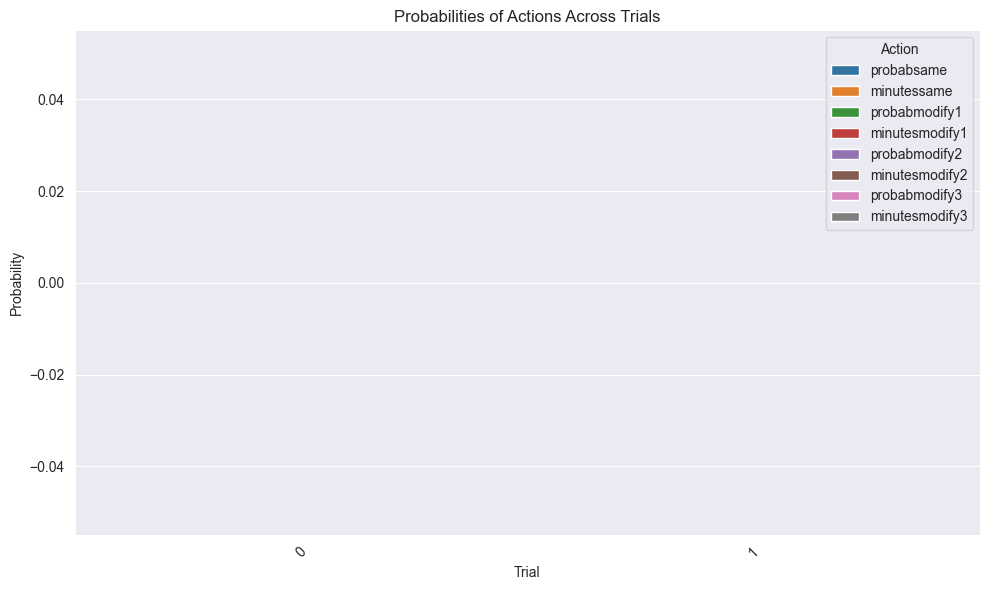

In [922]:
plot_probabilities(df)

In [45]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Full model for 'same' action
fullmodel_same = smf.mixedlm("probabsame ~ 0 + Trial", data=df, groups=df['u'])
fullmodel_same_result = fullmodel_same.fit(method=["lbfgs"])
print("\nFull Model Summary for same:\n")
print(fullmodel_same_result.summary())

# Reduced model for 'same' action
reducedmodel_same = smf.mixedlm("probabsame ~ 0", data=df, groups=df['u'])
reducedmodel_same_result = reducedmodel_same.fit()
print("\nReduced Model Summary for same:\n")
print(reducedmodel_same_result.summary())

# ANOVA for 'same' action
anova_result = sm.stats.anova_lm(fullmodel_same_result, reducedmodel_same_result)
print("\nANOVA for same:\n")
print(anova_result)


LinAlgError: Singular matrix

In [19]:
df['Trial'].isna().any()

False

In [21]:
# # # Calculate mean and standard deviation of the column
# mean_probab = df['probab'].mean()
# std_probab = df['probab'].std()
#
# #Normalize the column
# df['probab_normalized'] = (df['probab'] - mean_probab) / std_probab
import statsmodels.api as sm
import statsmodels.formula.api as smf

md = smf.mixedlm("probabsame ~ minutessame + Trial ", df, groups=df['u'])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

LinAlgError: Singular matrix

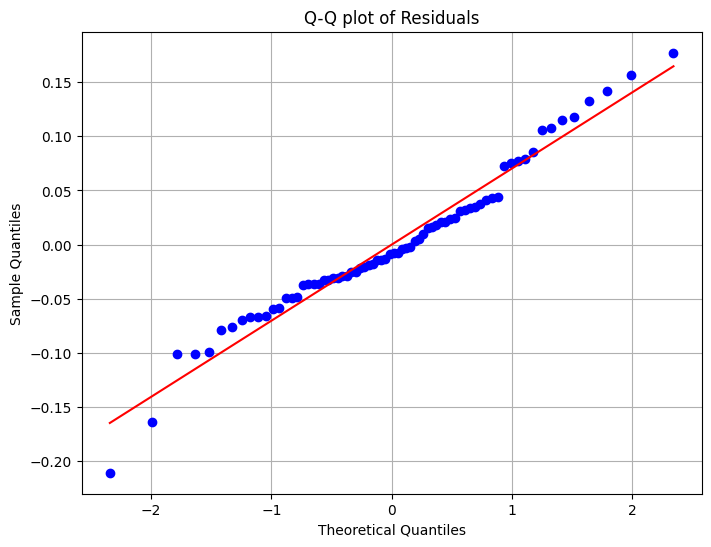

Shapiro-Wilk Test Statistic: 0.9723801612854004
P-value: 0.11396561563014984


In [742]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate Shapiro-Wilk test statistic and p-value
shapiro_statistic, shapiro_pvalue = stats.shapiro(mdf.resid)

# Plot Q-Q plot of the residuals
plt.figure(figsize=(8, 6))
stats.probplot(mdf.resid, dist="norm", plot=plt)
plt.title('Q-Q plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

# Print Shapiro-Wilk test statistic and p-value
print(f"Shapiro-Wilk Test Statistic: {shapiro_statistic}")
print(f"P-value: {shapiro_pvalue}")


Group Var is Random effects Intercept i.e User


Significance of Predictors:

The intercept term is highly significant (p < 0.001), indicating that when all predictors are zero, the expected value of the dependent variable probab is significantly different from zero.
The coefficient for the predictor Trial is not significant (p = 0.454), suggesting that there is no significant linear relationship between the predictor Trial and the dependent variable probab.
Variance Components:

The variance component associated with the random effect (Group Var) is estimated to be 76.229. This indicates the variability in the dependent variable probab between different groups or clusters in the data.
Model Fit:

The model seems to fit the data reasonably well, as indicated by the converged status and the negative log-likelihood value.
The scale parameter (6.3556) provides information about the dispersion or variability of the dependent variable probab.
Trial Coefficient:

Although the coefficient for the Trial predictor is not significant, its positive value (0.444) suggests a slight positive trend in the dependent variable probab as Trial increases, even though this trend is not statistically significant.
Group Structure:

The data contain 36 groups or clusters, each with a minimum group size of 2 and a maximum group size of 2. The mean group size is also 2.0.
In summary, the significant intercept indicates that the dependent variable has a non-zero mean when all predictors are zero. However, the lack of significance for the Trial predictor suggests that it may not have a significant linear relationship with the dependent variable. The large variance component for the random effect indicates substantial variability between groups, which should be considered when interpreting the results. Additionally, the insignificant trial coefficient suggests that any observed trends in the dependent variable over trials may not be reliably captured by the linear model.

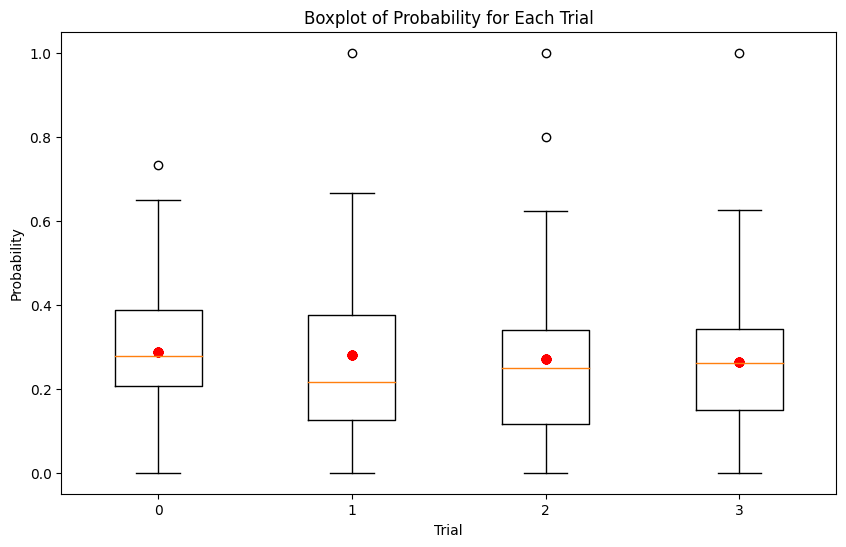

In [74]:
import matplotlib.pyplot as plt

# Create a boxplot for each Trail value
plt.figure(figsize=(10, 6))

# Plot boxplots of observed probab values for each Trail value
plt.boxplot([df[df["Trial"] == trail]["probab"] for trail in df["Trial"].unique()], positions=np.arange(1, len(df["Trial"].unique()) + 1), labels=df["Trial"].unique())

# Overlay predicted values as points
for trail in df["Trial"].unique():
    trail_data = df[df["Trial"] == trail]

    # Predict the normalized probab values using the fitted model
    predicted_values = mdf.predict(trail_data["Trial"])

    # Inverse normalize the predicted values
    predicted_values = predicted_values

    # Plot predicted values as points
    plt.plot(np.full(len(trail_data), np.where(df["Trial"].unique() == trail)[0][0] + 1), predicted_values, 'ro', alpha=0.5)

# Add labels and title
plt.xlabel("Trial")
plt.ylabel("Probability")
plt.title("Boxplot of Probability for Each Trial")

# Show plot
plt.show()
